In [121]:
# Import helps
from src.helpers import *

# Import base
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# tensorflow
import tensorflow as tf

pd.options.display.max_rows = 999

# Set seeds for reproducibility
set_seeds()

In [122]:
# class weight function
def cwts(y):
    c0, c1 = np.bincount(y)
    w0=(1/c0)*(len(y))/2 
    w1=(1/c1)*(len(y))/2 
    return {0: w0, 1: w1}

In [123]:
weights = {0: 0.5942162615255658, 1: 3.15346975088968}

In [124]:
tf.keras.backend.clear_session()

In [125]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv', parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv', parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv', parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv', parse_dates=True, index_col='unix')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False)

In [126]:
# Reshape the data into the correct format
seqlen = 1
featurelen = X_train.shape[-1]
train_tensors = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(X_val, y_val, seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, seqlen)

In [127]:
# Baseline model
inputs = tf.keras.Input(shape=(seqlen, featurelen))
x = tf.keras.layers.LSTM(36)(inputs)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [128]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 366)]          0         
                                                                 
 lstm (LSTM)                 (None, 36)                58032     
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 58069 (226.83 KB)
Trainable params: 58069 (226.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x=train_tensors, epochs=100, validation_data=val_tensors,
                    class_weight=weights, callbacks=callbacks)

Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 0.7331 - accuracy: 0.4232 - val_loss: 0.5911 - val_accuracy: 0.7996
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5408 - val_loss: 0.5546 - val_accuracy: 0.7964
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5814 - val_loss: 0.5584 - val_accuracy: 0.7773
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.5977 - val_loss: 0.5686 - val_accuracy: 0.7550
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.6061 - val_loss: 0.5775 - val_accuracy: 0.7390
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6138 - val_loss: 0.5847 - val_accuracy: 0.7242
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6171 - val_loss: 0.5905 - val_accuracy: 0.7119


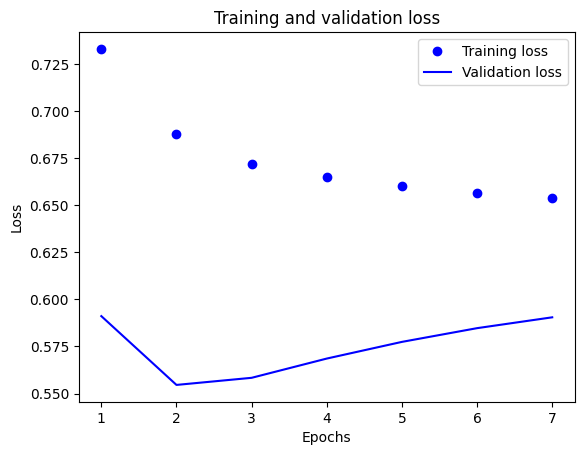

In [130]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

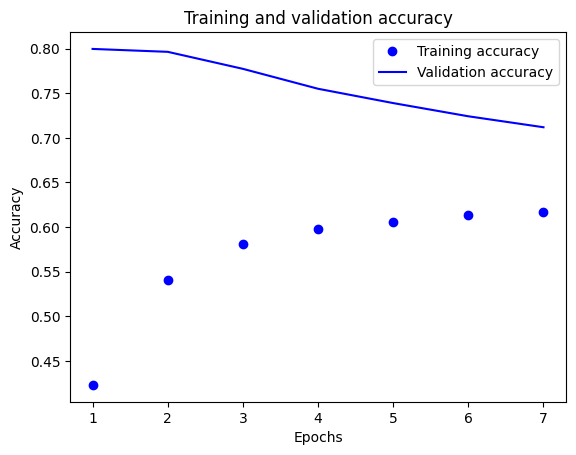

In [131]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [132]:
y_pred = np.where(model.predict(test_tensors) > 0.5, 1, 0)

42/42 [==============================] - 0s 1ms/step


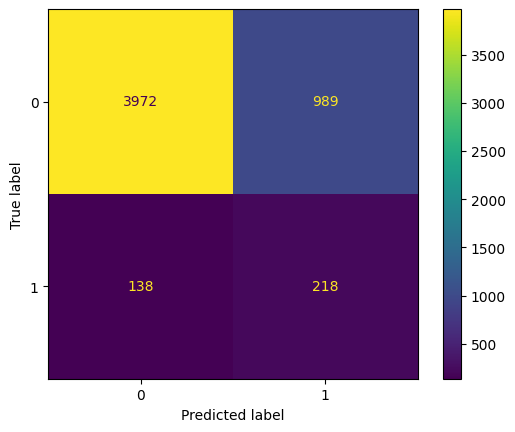

In [133]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.values, y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()